In [1]:
from orion.data import load_signal, load_anomalies

In [2]:
signal_name = 'S-1'

data = load_signal(signal_name)

anomalies = load_anomalies(signal_name)

data.head()

,timestamp,value
0,1222819200,-0.366359
1,1222840800,-0.394108
2,1222862400,0.403625
3,1222884000,-0.362759
4,1222905600,-0.370746


In [3]:
from mlblocks import MLPipeline

pipeline_name = 'TimesFM'

pipeline = MLPipeline(pipeline_name)

2024-11-24 15:54:54.304980: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.5 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 2.56 seconds.
Restoring checkpoint from /home/linhnk/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.24 seconds.
Jitting decoding.
Jitted decoding in 18.02 seconds.


In [4]:
pipeline.primitives

['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'sklearn.preprocessing.StandardScaler',
 'orion.primitives.timesfm.TimesFM',
 'orion.primitives.timeseries_errors.regression_errors',
 'orion.primitives.timeseries_anomalies.find_anomalies']

In [5]:
context = pipeline.fit(data, output_=0)
context.keys()

dict_keys(['X', 'index'])

In [6]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [-0.36635895]
entry at 1222840800 has value [-0.39410778]
entry at 1222862400 has value [0.4036246]
entry at 1222884000 has value [-0.36275906]
entry at 1222905600 has value [-0.37074649]


In [7]:
step = 1

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X'])

In [8]:
step = 2

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X'])

In [9]:
# after scaling the data between [-1, 1]

for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [-0.4818325]
entry at 1222840800 has value [-0.54231192]
entry at 1222862400 has value [1.19636972]
entry at 1222884000 has value [-0.47398644]
entry at 1222905600 has value [-0.49139529]


In [10]:
step = 3

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

(9893, 256, 1)


dict_keys(['index', 'X', 'y_hat', 'y'])

In [13]:
context['y'].shape

(9893, 1)

In [14]:
step = 4

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'y_hat', 'X', 'y', 'errors'])

In [15]:
step = 5

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

/home/linhnk/Orion/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/linhnk/Orion/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/linhnk/Orion/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/linhnk/Orion/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/linhnk/Orion/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/linhnk/Orion/.venv/lib/python3.10/site-packages/s

dict_keys(['index', 'y_hat', 'errors', 'X', 'y', 'anomalies'])

In [16]:
context['anomalies']

array([[1.39853520e+09, 1.40646240e+09, 4.57024721e-01]])

In [17]:
import matplotlib.pyplot as plt

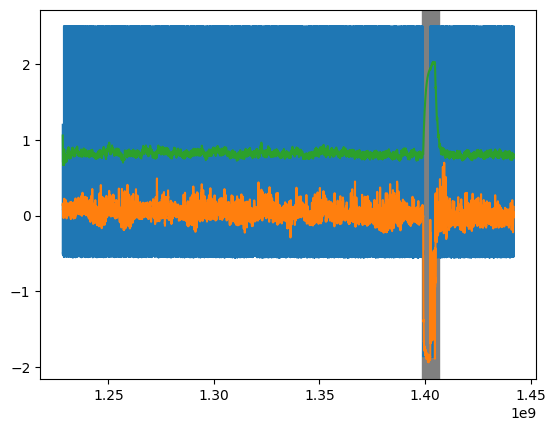

In [22]:
plt.plot(context['index'], context['y'])
plt.plot(context['index'], context['y_hat'])
plt.plot(context['index'], context['errors'])
plt.axvspan(context['anomalies'][0][0], context['anomalies'][0][1], color='grey')

In [23]:
from orion.data import load_anomalies

ground_truth = load_anomalies('S-1')
ground_truth

,start,end
0,1398168000,1407823200


In [24]:
anomalies = []
for ano in context['anomalies']:
    anomalies.append((ano[0], ano[1]))
anomalies

[(1398535200.0, 1406462400.0)]

In [25]:
from orion.evaluation import contextual_confusion_matrix, contextual_f1_score

start, end = context['index'][0], context['index'][-1]

contextual_confusion_matrix(ground_truth, anomalies, start = start, end = end, weighted=False)

(None, 0, 0, 1)

In [26]:
contextual_f1_score(ground_truth, anomalies, start = start, end = end, weighted=False)

1.0